In [1]:
%load_ext autoreload
%autoreload 2


In [62]:
from toolkit.process import AnalysisObject
from toolkit.populations import definePremotorPopulation
from toolkit.populations import defineVisualPopulation
from toolkit.populations import definePremotorPopulationExclusive
from toolkit.populations import defineVisualPopulationExclusive
from toolkit.populations import defineVisuomotorPopulation
from toolkit.populations import defineQualityUnits
from toolkit.saccades import parseSaccadeType
from toolkit.saccades import calculateSaccadeAmplitudes
from toolkit.saccades import calculateSaccadeStartPoint
from toolkit.saccades import calculateSaccadeEndPoint
from toolkit.saccades import computeNormalizedFiringRate, generateSaccadeMetricArray
from toolkit.populations import createTrialArray
from toolkit.populations import specifyTrialTypes
from toolkit.populations import trialAveragedPCA
from toolkit.populations import getUnitDepth
from toolkit.populations import getUnitCoords
from toolkit.plots import plotPCA3D
from toolkit.plots import plotPETH
from toolkit.plots import plotKDE
from toolkit.plots import plotUnitDepth
from toolkit.plots import plotUnitDepthOverBrain
from toolkit.plots import plotRaster
from toolkit.opto import runZetaTestForOpto
from toolkit.opto import defineOptoPopulation
from toolkit.prediction import predictSaccadeMetrics, plotPredictedVSActual
import os
import numpy as np

In [49]:
fileList = [
           '/media/jbhunt/Seagate Portable Drive/2023-07-24/mlati9',
             '/media/jbhunt/Seagate Portable Drive/2023-07-25/mlati10',
             '/media/jbhunt/Seagate Portable Drive/2023-07-26/mlati9',
             '/media/jbhunt/Seagate Portable Drive/2023-07-27/mlati10',
             '/media/jbhunt/Seagate Portable Drive/2023-07-28/mlati9',
             '/media/jbhunt/Seagate Portable Drive/2023-07-31/mlati10',
             '/media/jbhunt/Seagate Portable Drive/2023-08-01/mlati10']

In [15]:
import json
with open('/home/jbhunt/Downloads/structure_graph_with_sets.json') as f:
    s = json.load(f)
print(s)

[{'acronym': 'root', 'atlas_id': -1, 'color_hex_triplet': 'FFFFFF', 'depth': 0, 'failed': False, 'failed_facet': 734881840, 'graph_id': 1, 'graph_order': 0, 'hemisphere_id': 3, 'id': 997, 'name': 'root', 'neuro_name_structure_id': None, 'neuro_name_structure_id_path': None, 'ontology_id': 1, 'parent_structure_id': None, 'safe_name': 'root', 'sphinx_id': 1, 'st_level': 0, 'structure_id_path': '/997/', 'structure_name_facet': 385153371, 'weight': 8690, 'structure_sets': [{'description': 'Structures whose surfaces are represented by a precomputed mesh', 'id': 691663206, 'name': 'Mouse Brain - Has Surface Mesh'}]}, {'acronym': 'grey', 'atlas_id': 0, 'color_hex_triplet': 'BFDAE3', 'depth': 1, 'failed': False, 'failed_facet': 734881840, 'graph_id': 1, 'graph_order': 1, 'hemisphere_id': 3, 'id': 8, 'name': 'Basic cell groups and regions', 'neuro_name_structure_id': None, 'neuro_name_structure_id_path': None, 'ontology_id': 1, 'parent_structure_id': 997, 'safe_name': 'Basic cell groups and reg

In [135]:
for base in fileList:
    h5file = os.path.join(base, 'output.hdf')
    clusterFile = os.path.join(base,'ephys/sorting/manual/spike_clusters.npy')
    premotorUnits = definePremotorPopulation(h5file, clusterFile)
    visualUnits = defineVisualPopulation(h5file, clusterFile)
    visuomotorUnits = defineVisuomotorPopulation(premotorUnits, visualUnits)
    print(len(premotorUnits))
    #print(visualUnits)

12
21
21
6
41
14
12
19


In [6]:
for base in fileList[0:1]:
    h5file = os.path.join(base, 'output.hdf')
    driven, spontaneous = parseSaccadeType(h5file)
    amplitudes = calculateSaccadeAmplitudes(h5file, spontaneous)
    starts = calculateSaccadeStartPoint(h5file, spontaneous)
    ends = calculateSaccadeEndPoint(h5file, spontaneous)
    print(starts, ends)
    #print(amplitudes)

[-2.861279517351594, -2.8463486364687745, -3.16619229468329, -3.187677750296557, -3.1686998294079243, -2.9499225830455402, -2.763725153376696, -2.249013213360768, -3.48577838108964, -3.4906390272469476, -3.53679025781901, -2.9486707040099813, -2.993416087950256, -2.5973184032853363, -2.67975705415683, -3.2009794157893365, 0.4534397671729229, 0.3239741257406733, 0.12155619890422617, 0.1818219566842989, 0.1412319495945511] [9.246746819355941, 14.807534660375481, -0.29312804304030127, 6.266473589923149, 12.337999885458423, -2.3242131750010953, -0.5651904993089957, 1.402196111543709, -0.8323121417861616, 6.203787168846832, 8.811574527256555, 9.214796104650448, 1.6067837620155299, 16.123865627300535, 3.1652300212611175, 8.380720773887933, 3.0484696549747783, -6.193584366047802, -5.6538099692241275, -1.823747284088594, -4.299723507975522]


In [29]:
session = AnalysisObject(h5file)
totalSaccadeTimes = session.load('saccades/predicted/left/timestamps')[:, 0]

In [34]:
import numpy as np
for time in spontaneous:
    print(np.where(totalSaccadeTimes == time)[0])


[620]
[658]
[723]
[831]
[905]
[906]
[907]
[1049]
[1107]
[1265]
[1565]
[1820]
[1846]
[1911]
[1938]
[1981]
[1982]
[1983]
[1984]
[2050]
[2141]


In [59]:
bins = np.arange(-0.5, 0.6, 0.1)
session = AnalysisObject(h5file)
population = session._population()
#trials = session.load('saccades/predicted/left/timestamps')[:, 0]
trials = session.load('stimuli/dg/probe/timestamps')
trialList = createTrialArray(h5file, bins, visuomotorUnits, trials)

In [49]:
import scipy.interpolate

In [52]:
scipy.interpolate

<module 'scipy.interpolate' from '/home/jbhunt/anaconda3/envs/sandbox/lib/python3.10/site-packages/scipy/interpolate/__init__.py'>

In [60]:
t_type_ind, trial_types = specifyTrialTypes(h5file, saccade=False)
pcs = trialAveragedPCA(trialList, t_type_ind, trial_types, 6)

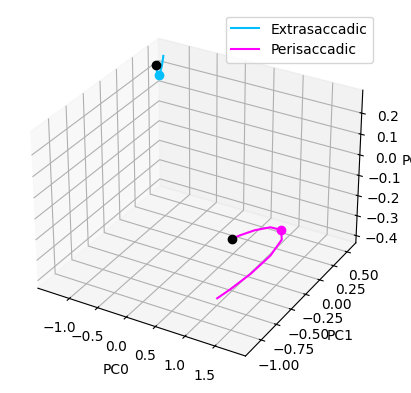

In [121]:
dimensions = [0, 1, 2]
ax = plotPCA3D(pcs, trial_types, dimensions, 4, saveFig=True)

In [76]:
pcs.shape

(10, 10, 2)

AttributeError: 'Axes' object has no attribute 'savefig'

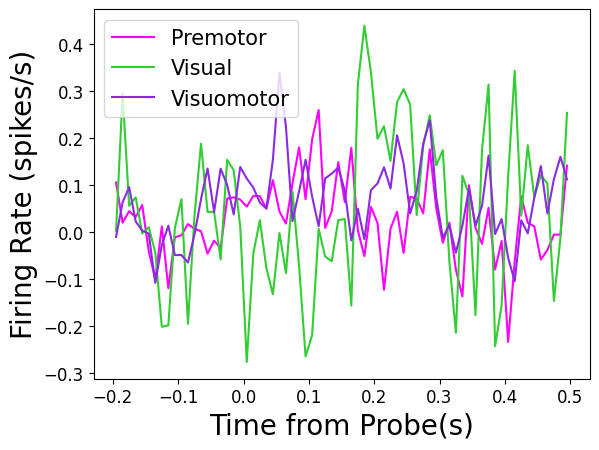

In [157]:
base = fileList[7]
h5file = os.path.join(base, 'output.hdf')
clusterFile = os.path.join(base,'ephys/sorting/manual/spike_clusters.npy')
session = AnalysisObject(h5file)
saccades = session.load('saccades/predicted/left/timestamps')
sac = saccades[:, 0]
probe = session.load('stimuli/dg/probe/timestamps')
premotorUnits = definePremotorPopulation(h5file, clusterFile)
visualUnits = defineVisualPopulation(h5file, clusterFile)
premotor = definePremotorPopulationExclusive(h5file, clusterFile)
visual = defineVisualPopulationExclusive(h5file, clusterFile)
visuomotor = defineVisuomotorPopulation(premotorUnits, visualUnits)
fig, ax = plotKDE(h5file, premotor, probe, 'magenta', -0.2, 0.5, 0.01, label='Premotor', avgOnly=True, saveFig=False)
fig, ax = plotKDE(h5file, visual, probe, 'limegreen', -0.2, 0.5, 0.01, label='Visual', avgOnly=True, fig=fig, ax=ax, saveFig=False)
fig, ax = plotKDE(h5file, visuomotor, probe, 'blueviolet', -0.2, 0.5, 0.01, label='Visuomotor', avgOnly=True, fig=fig, ax=ax, saveFig=True)
ax.set_ylabel('Firing Rate (spikes/s)', fontsize=20)
ax.set_xlabel('Time from Probe(s)', fontsize=20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=15)
ax.savefig('probePSTH', format='svg')

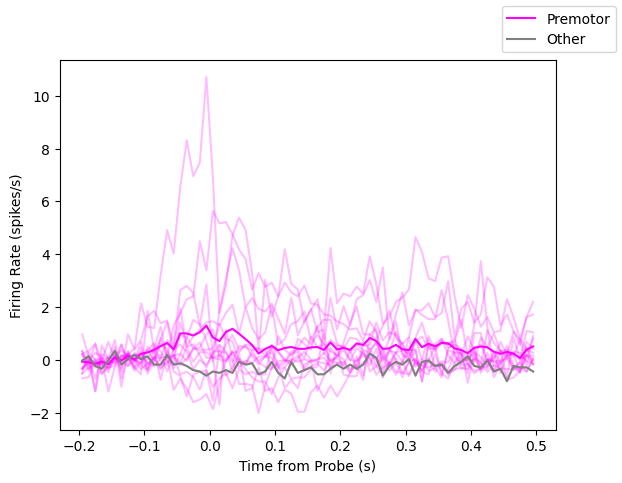

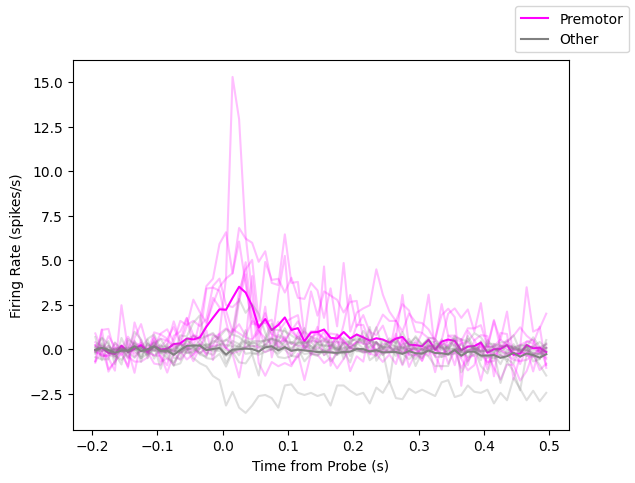

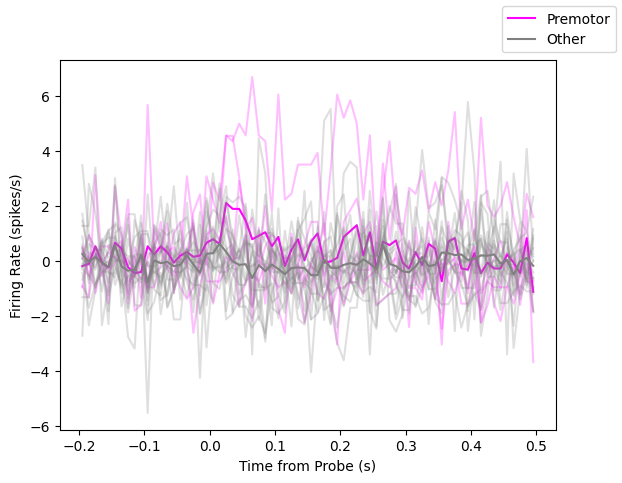

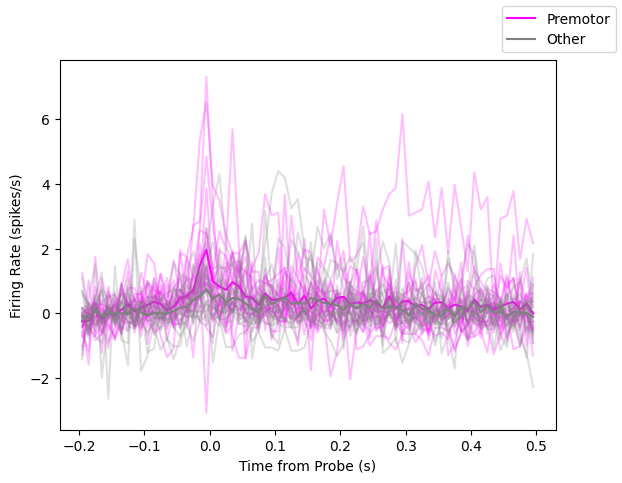

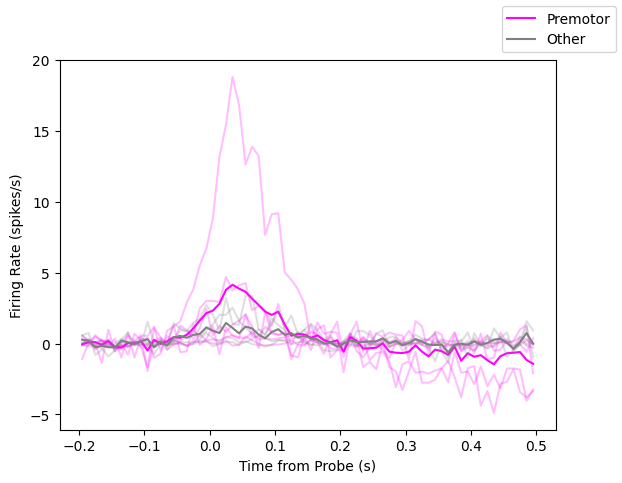

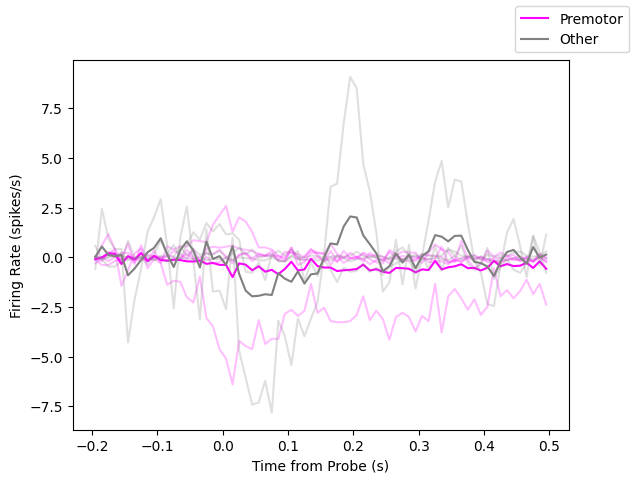

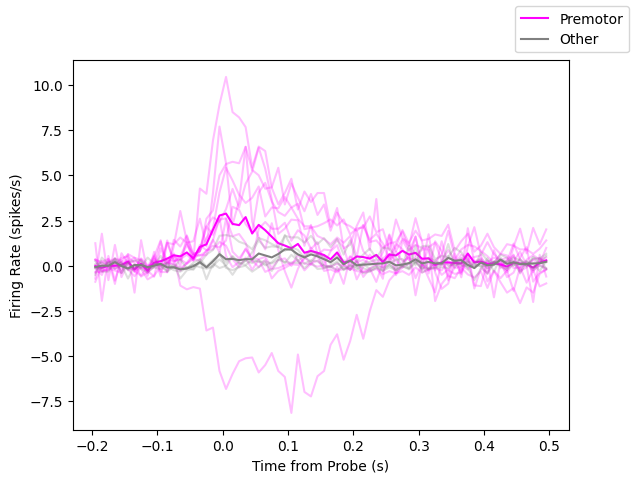

In [59]:
import unit_localizer as ul
for base in fileList:
#base = fileList[2]
    h5file = os.path.join(base, 'output.hdf')
    clusterFile = os.path.join(base,'ephys/sorting/manual/spike_clusters.npy')
    uniqueSpikeClusters = np.unique(np.load(clusterFile))
    session = AnalysisObject(h5file)
    population = session._population()
    labels = session.load('nptracer/labels')
    saccades = session.load('saccades/predicted/left/timestamps')
    sac = saccades[:, 0]
    probe = session.load('stimuli/dg/probe/timestamps')
    premotorUnits = definePremotorPopulation(h5file, clusterFile)
    visualUnits = defineVisualPopulation(h5file, clusterFile)
    premotor = definePremotorPopulationExclusive(h5file, clusterFile)
    visual = defineVisualPopulationExclusive(h5file, clusterFile)
    visuomotor = defineVisuomotorPopulation(premotorUnits, visualUnits)
    brainAreas = ul.translateBrainAreaIdentities(labels, '/home/jbhunt/Downloads/structure_graph_with_sets.json') 
    none = list()
    ampCutoff = session.load('metrics/ac')
    presenceRatio = session.load('metrics/pr')
    firingRate = session.load('metrics/fr')
    isiViol = session.load('metrics/rpvr')
    qualityLabels = session.load('metrics/ql')
    for index, unit in enumerate(population):
        if brainAreas[index] in ['SCsg','SCop', 'SCig', 'SCiw', 'SCdg']:
            if unit.cluster not in premotor:
                if unit.cluster not in visual:
                    if unit.cluster not in visuomotor:
                        if qualityLabels is not None and qualityLabels[index] in (0, 1):
                                continue
                        if ampCutoff[index] <= 0.1:
                            if presenceRatio[index] >= 0.9:
                                if firingRate[index] >= 0.2:
                                    if isiViol[index] <= 0.5:
                                        unit = uniqueSpikeClusters[index]
                                        none.append(unit)
    fig, ax = plotPETH(h5file, premotor, sac, 'magenta', -0.2, 0.5, 0.01, label='Premotor', avgOnly=False, saveFig=False)
    fig, ax = plotPETH(h5file, none, sac, 'gray', -0.2, 0.5, 0.01, label='Other', avgOnly=False, fig=fig, ax=ax, saveFig=False)
    ax.plot(0, 0, color='magenta', label='Premotor')
    ax.plot(0, 0, color='grey', label='Other')
    #ax.set_ylim(-10, 10)
    fig.legend()
    ax.set_xlabel('Time from Probe (s)')
    ax.set_ylabel('Firing Rate (spikes/s)')

In [207]:
print(none)
print(visual)

[1, 3, 5, 6, 7, 9, 11, 12, 22, 25, 36, 38, 49, 50, 52, 53, 57, 58, 59, 60, 61, 63, 65, 66, 68, 70, 71, 72, 73, 81, 83, 85, 86, 88, 93, 95, 99, 100, 103, 106, 107, 108, 109, 110, 111, 115, 120, 121, 126, 129, 130, 133, 147, 150, 151, 153, 157, 159, 161, 163, 170, 172, 174, 175, 177, 178, 180, 182, 183, 187, 188, 191, 192, 194, 196, 198, 261, 292, 302, 323, 367, 410, 412, 471]
[287, 328, 333]


In [159]:
for i, base in enumerate(fileList):
    h5file = os.path.join(base, 'output.hdf')
    clusterFile = os.path.join(base,'ephys/sorting/manual/spike_clusters.npy')
    premotorUnits = definePremotorPopulation(h5file, clusterFile)
    visualUnits = defineVisualPopulation(h5file, clusterFile)
    premotor = definePremotorPopulationExclusive(h5file, clusterFile)
    visual = defineVisualPopulationExclusive(h5file, clusterFile)
    visuomotor = defineVisuomotorPopulation(premotorUnits, visualUnits)
    if i == 0:
        depthDict = getUnitDepth(h5file, premotor, visual, visuomotor)
    else:
        depthDict = getUnitDepth(h5file, premotor, visual, visuomotor, depthDict=depthDict)

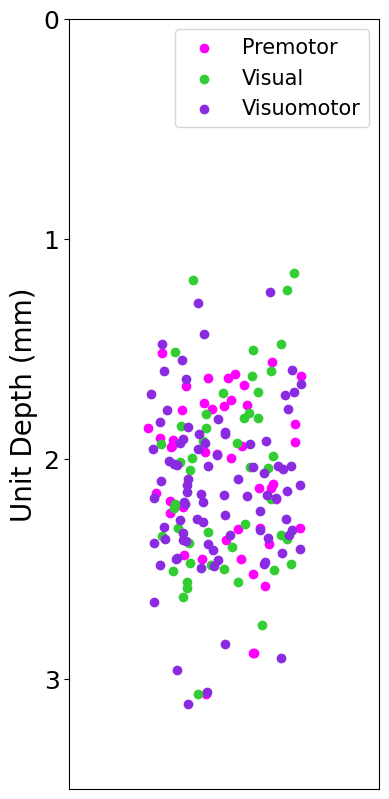

In [160]:
fig, ax = plotUnitDepth(depthDict, saveFig=True)

In [173]:
for i, base in enumerate(fileList):
    h5file = os.path.join(base, 'output.hdf')
    clusterFile = os.path.join(base,'ephys/sorting/manual/spike_clusters.npy')
    premotorUnits = definePremotorPopulation(h5file, clusterFile)
    visualUnits = defineVisualPopulation(h5file, clusterFile)
    premotor = definePremotorPopulationExclusive(h5file, clusterFile)
    visual = defineVisualPopulationExclusive(h5file, clusterFile)
    visuomotor = defineVisuomotorPopulation(premotorUnits, visualUnits)
    if i == 0:
        depthCoords = getUnitCoords(h5file, premotor, visual, visuomotor)
    else:
        depthCoords = getUnitCoords(h5file, premotor, visual, visuomotor, depthCoords=depthCoords)

In [183]:
depthCoords['premotor'][i][0]

517.218774271591

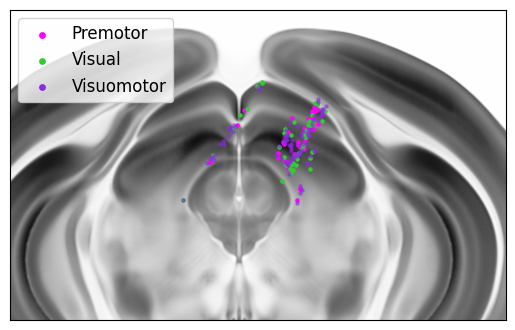

In [196]:
plotUnitDepthOverBrain(depthCoords, saveFig=False)

In [119]:
session = AnalysisObject(h5file)
session.listAllDatasets()

barcodes/labjack/indices
barcodes/labjack/trains
barcodes/labjack/values
barcodes/neuropixels/indices
barcodes/neuropixels/trains
barcodes/neuropixels/values
direction/preference/pref
direction/preference/premotor/pref
direction/preference/premotor/pval
direction/preference/pval
epochs/dg
epochs/fs
epochs/mb
epochs/sn/pre
frames/left/dropped
frames/left/intervals
frames/left/timestamps
frames/right/dropped
frames/right/intervals
frames/right/timestamps
labjack/cameras/missing
labjack/cameras/timestamps
labjack/matrix
labjack/timespace
metrics/ac
metrics/dsi
metrics/fr
metrics/lpi
metrics/pr
metrics/ql
metrics/rpvr
nptracer/labels
nptracer/points
nptracer/transformed
pose/corrected
pose/decomposed
pose/filtered
pose/interpolated
pose/missing/left
pose/missing/right
pose/reoriented
pose/uncorrected
prediction/saccades/direction/X
prediction/saccades/direction/y
prediction/saccades/epochs/X
prediction/saccades/epochs/y
prediction/saccades/epochs/z
regression/all/prediction/contra
regressi

/home/jbhunt/Code/felsen-analysis/myphdlib/toolkit/plots.py:112: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fig, ax = plt.subplots()


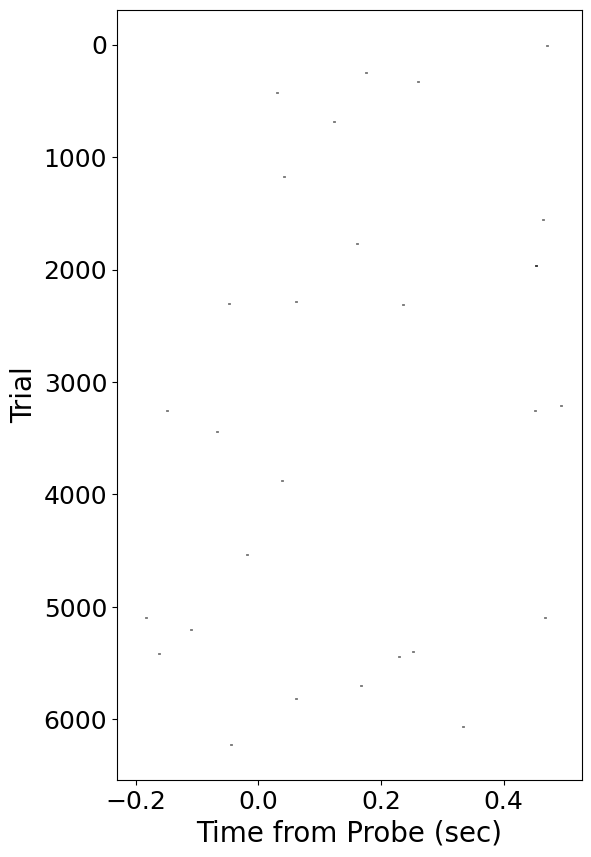

In [170]:
population = session._population()
spikeTimes = population[10].timestamps
eventTimes = session.load('stimuli/dg/probe/timestamps')
fig, ax = plotRaster(eventTimes, spikeTimes, [-0.2, 0.5], eventType='Probe')

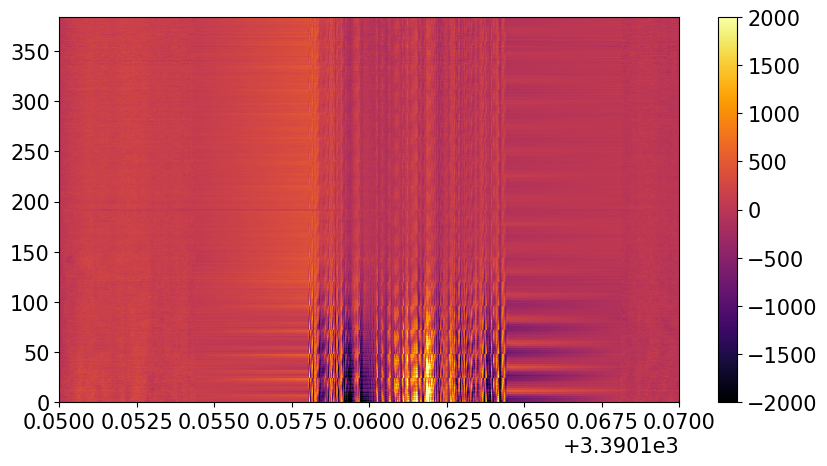

In [325]:
from toolkit.opto import plotRawNeuropixelsData
t2plot = [3390.15, 3390.17]
folderPath = '/media/jbhunt/EPHYS-01/2025-06-18_11-34-05/Record Node 101'
datPath = '/media/jbhunt/EPHYS-01/2025-06-18_11-34-05/preprocessedaveragelinearoffset.dat'
fig, ax = plotRawNeuropixelsData(t2plot, folderPath, datPath, vmin=-2000, vmax=2000)

In [24]:
#h5file = '/media/jbhunt/EPHYS-01/6-18-25/testNOPE/output.hdf'
#clusterFile = '/media/jbhunt/EPHYS-01/2025-06-18_11-34-05/linearoffset/kilosort4/spike_clusters.npy'
qualityUnits = defineQualityUnits(h5file, clusterFile)

In [25]:
len(qualityUnits)

35

In [42]:
from myphdlib.interface.nope import NOPESession
h5file = '/media/jbhunt/EPHYS-01/6-18-25/testNOPE/output.hdf'
session = AnalysisObject(h5file)
session2 = NOPESession('/media/jbhunt/EPHYS-01/6-18-25/testNOPE')
matrix = session.load('labjack/matrix')
opto = matrix[:, 11]
optoIndices = np.where(np.diff(opto) == 1)[0]
optoTimes = session2.computeTimestamps(optoIndices)
runZetaTestForOpto(h5file, optoTimes, responseWindow=(0, 0.0), latencyMetric='onset')

In [43]:
#clusterFile = '/media/jbhunt/EPHYS-01/6-18-25/testNOPE/ephys/sorting/manual/spike_clusters.npy'
optoUnits = defineOptoPopulation(h5file, clusterFile)

In [44]:
print(len(optoUnits))

22


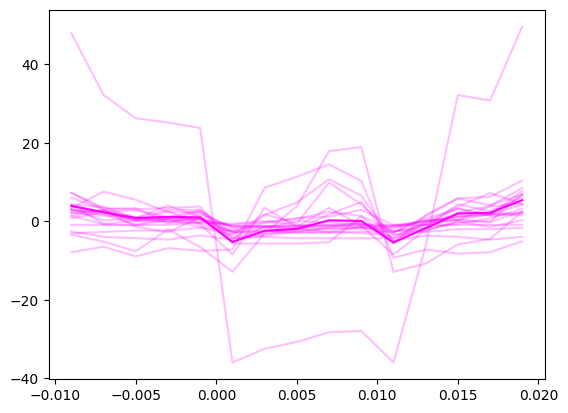

In [47]:
fig, ax = plotPETH(h5file, optoUnits, optoTimes, 'magenta', -0.01, 0.02, 0.002, label='Opto', avgOnly=False, saveFig=False)
#ax.set_ylim(-15, 15)

Text(0, 0.5, 'FR (spikes/sec)')

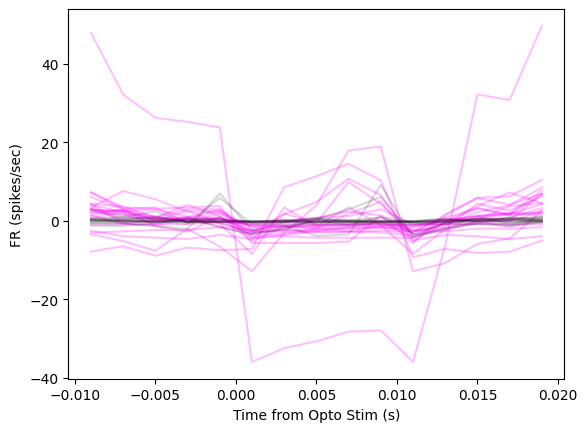

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
frList = list()
session = AnalysisObject(h5file)
population = session._population()
for unit in population:
    if unit.cluster in qualityUnits:
        if unit.cluster in optoUnits:
            spikeTimes = unit.timestamps
            t, fr = unit.peth(optoTimes, (-0.01, 0.02), 0.002)
            baseline = np.mean(fr[0:10])
            corrected = fr - baseline
            plt.plot(t, corrected, color='magenta', alpha=0.25)
            frList.append(fr)
        else:
            spikeTimes = unit.timestamps
            t, fr = unit.peth(optoTimes, (-0.01, 0.02), 0.002)
            baseline = np.mean(fr[0:10])
            corrected = fr - baseline
            plt.plot(t, corrected, color='k', alpha=0.15)
            frList.append(fr)
frAvg = np.mean(frList, axis=0)
#plt.plot(t, frAvg, color='k')
#plt.ylim(-50, 50)
plt.xlabel('Time from Opto Stim (s)')
plt.ylabel('FR (spikes/sec)')

Text(0, 0.5, 'Neuron')

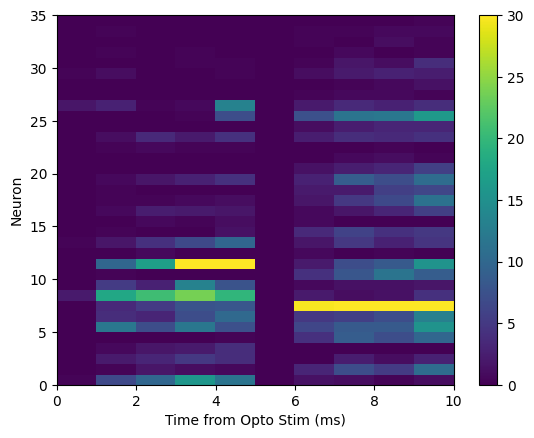

In [46]:
plt.pcolor(frList, vmax=30)
plt.colorbar()
plt.xlabel('Time from Opto Stim (ms)')
plt.ylabel('Neuron')

In [94]:
h5file = '/media/jbhunt/Seagate Portable Drive/2023-07-24/mlati9/output.hdf'
clusterFile = '/media/jbhunt/Seagate Portable Drive/2023-07-24/mlati9/ephys/sorting/manual/spike_clusters.npy'
session = AnalysisObject(h5file)
premotorUnits = definePremotorPopulation(h5file, clusterFile)
saccades = session.load('saccades/predicted/left/timestamps')
driven, spontaneous = parseSaccadeType(h5file)
z = computeNormalizedFiringRate(h5file, premotorUnits, driven, [-0.3, 0])
ampList = calculateSaccadeAmplitudes(h5file, driven)
startList = calculateSaccadeStartPoint(h5file, driven)
endList = calculateSaccadeEndPoint(h5file, driven)
sacMetrics = generateSaccadeMetricArray(h5file, ampList, startList, endList)
predicted, scoreTrain, scoreTest = predictSaccadeMetrics(driven, z, sacMetrics)

In [102]:
ampList = calculateSaccadeAmplitudes(h5file, driven)
predicted, scoreTrain, scoreTest, testIndices = predictSaccadeMetrics(driven, z, sacMetrics)

In [106]:
np.array(ampList)[testIndices]

array([ 8.79545427,  1.41051695,  1.46571496,  4.63748116,  9.98407825,
        4.68084969,  1.36759037,  8.74264725, 10.63097022, 18.91050813,
        9.00375379,  6.29757604,  9.13676733,  7.85354637,  3.7708153 ,
        1.16041712,  6.64676162,  3.66375049, 10.67545413,  2.73252427,
        2.52462172,  0.55420675, 10.8182326 ,  9.01078007,  2.98511159,
       23.43067951, 12.74405292,  3.68393595,  0.31765711,  7.76866164,
        3.22060809,  7.33398665,  5.97319238, 14.11082903,  5.06562644,
       10.3960678 ,  2.95312601, 12.13012833, 11.21447149, 14.88318423,
       12.79728041,  1.53242762,  2.66684937,  3.35962362, 14.0033047 ,
        9.63703085,  4.76789327,  8.66043985,  1.7474803 ,  3.35637672,
        7.65925073,  0.27744241,  0.52058192,  2.38516052,  4.32483627,
        3.48796537,  0.84340438,  4.77033854,  0.8342737 ,  5.34017917,
        3.00689262,  4.61725709,  2.87624744, 19.27452831,  0.        ,
        2.92046805,  2.72705653,  4.28969415,  8.25797995,  5.79

Text(15, -10, 'Score: 0.26')

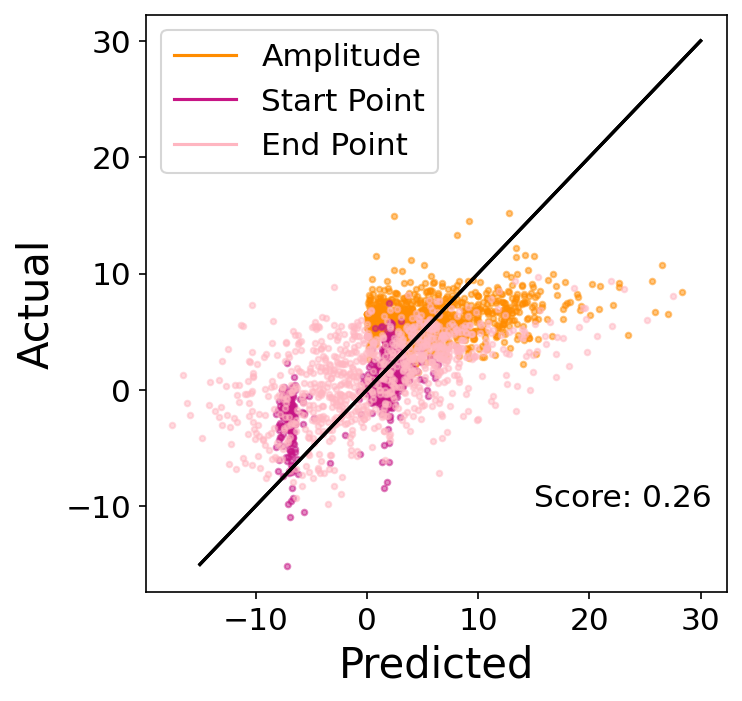

In [116]:
fig, ax = plotPredictedVSActual(predicted, np.array(ampList)[testIndices], 'amplitude', 'darkorange', min=-15, max = 30, fig=None, ax=None)
fig, ax = plotPredictedVSActual(predicted, np.array(startList)[testIndices], 'start', 'mediumvioletred', min=-15, max = 30, fig=fig, ax=ax)
fig, ax = plotPredictedVSActual(predicted, np.array(endList)[testIndices], 'end', 'lightpink', min=-15, max = 30, fig=fig, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.plot(0, 0, color='darkorange', label='Amplitude')
ax.plot(0, 0, color='mediumvioletred', label='Start Point')
ax.plot(0, 0, color='lightpink', label='End Point')
ax.legend()
ax.text(15, -10, f'Score: {str(scoreTest)[0:4]}', fontsize=15)